In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 6, 
                                   'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.title_fontsize' : 5.5,
                                   'legend.fontsize' : 5.5,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})

## Neural activation state space

/tmp/ipykernel_268750/3473585495.py:14: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('saved/neural_activation_space-3d.png', dpi=300)


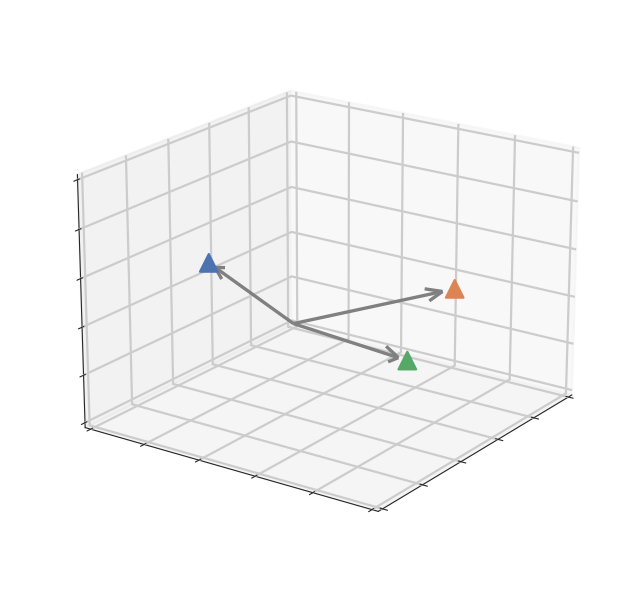

In [126]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')

vecs = np.array([[0.7, 0.2, 0.6], [0.3, 0.8, 0.5], [0.7, 0.9, 0.4]])
ax.quiver(0, 0, 0, vecs[:, 0], vecs[:, 1], vecs[:, 2],
          arrow_length_ratio=0.1, length=0.93, color='gray')
ax.scatter(vecs[:, 0], vecs[:, 1], vecs[:, 2], 
           depthshade=False, marker='^', s=40, c=sns.color_palette()[:3])

ax.set(xticklabels=[], yticklabels=[], zticklabels=[],
       xlim=[0, 1], ylim=[0, 1], zlim=[0, 1])
ax.view_init(elev=20, azim=35)

plt.savefig('saved/neural_activation_space-3d.png', dpi=300)
plt.show()

## Dynamics & Attractor helpers

In [2]:
import jax.numpy as jnp
from jax import grad, vmap


def make_grid(x_range, y_range, n_points):
    aspect_ratio = (y_range[1] - y_range[0]) / (x_range[1] - x_range[0])
    xx, yy = jnp.meshgrid(jnp.linspace(*x_range, n_points), jnp.linspace(*y_range, int(n_points * aspect_ratio)))
    return xx, yy


def sample_func(func, x_range, y_range, n_points):
    xx, yy = make_grid(x_range, y_range, n_points)
    func = vmap(vmap(func, (0, 0), 0), (0, 0), 0)
    out = func(xx, yy)
    return xx, yy, out


def sample_trajectory(dynamics_func, s0, n_steps, step_size):
    s0 = jnp.array(s0)
    dynamics_func = vmap(dynamics_func, (0, 0), 0)
    x, y = s0
    traj_x, traj_y = [x], [y]
    speeds = []
    for _ in range(n_steps):
        delta_x, delta_y = dynamics_func(x, y)
        x += step_size * delta_x
        y += step_size * delta_y
        traj_x.append(x)
        traj_y.append(y)
        speeds.append(jnp.sqrt(delta_x**2 + delta_y**2))
    trajectories = jnp.stack([jnp.stack(traj_x), jnp.stack(traj_y)], axis=-1)
    trajectories = trajectories.transpose(1, 0, 2)
    speeds = jnp.stack(speeds).transpose(1, 0)
    return trajectories, speeds


def get_basins_of_attraction(dynamics_func, x_range, y_range, n_points, n_steps, step_size):
    xx, yy = make_grid(x_range, y_range, n_points)
    _, speeds = sample_trajectory(dynamics_func, (xx.flatten(), yy.flatten()), 
                                  n_steps, step_size)
    final_speeds = speeds[:, -1]
    final_speeds = final_speeds.reshape(xx.shape)
    is_basin = final_speeds < 1e-5
    return xx, yy, is_basin


def dynamics_from_energy(energy_func):
    grad_func = grad(energy_func, (0, 1))
    dynamics_func = lambda x, y: tuple(-1 * out for out in grad_func(x, y))
    return dynamics_func

In [3]:
def plot_energy_func(ax, 
                     energy_func,
                     x_range=[-2, 2], 
                     y_range=[-2, 2], 
                     n_points=1000,
                     **kwargs):
    xx, yy, zz = sample_func(energy_func, 
                             x_range=x_range, 
                             y_range=y_range, 
                             n_points=n_points)
    ax.contourf(xx, yy, zz, levels=30, cmap='RdBu_r', alpha=0.3, **kwargs)
    

def plot_vector_field(ax,
                      dynamics_func, 
                      x_range=[-2, 2], 
                      y_range=[-2, 2], 
                      n_points=10,
                      **kwargs):
    xx_p, yy_p, (xx_p_grad, yy_p_grad) = sample_func(dynamics_func, 
                                                     x_range=x_range, 
                                                     y_range=y_range, 
                                                     n_points=n_points)
    ax.quiver(xx_p, yy_p, xx_p_grad, yy_p_grad, angles='xy', scale_units='xy', color='gray', **kwargs)


def plot_trajectories(ax,
                      dynamics_func,
                      s0,
                      n_steps=50, 
                      step_size=1,
                      trajectory_clip=None,
                      final_marker=True,
                      **kwargs):
    trajectories, _ = sample_trajectory(dynamics_func, 
                                        s0=s0, 
                                        n_steps=n_steps, 
                                        step_size=step_size)
    for i, traj in enumerate(trajectories):
        if trajectory_clip is not None and trajectory_clip[i] is not None:
            traj = traj[:trajectory_clip[i]]
        ax.scatter(traj[:-1, 0][::-1], traj[:-1, 1][::-1], 
                   color=sns.color_palette()[0],
                   linewidth=0,
                   alpha=0.9,
                   s=10 * np.linspace(0.15, 1, num=len(traj) - 1),
                   **kwargs)
        if  isinstance(final_marker, bool) and final_marker or \
            not isinstance(final_marker, bool) and final_marker[i]:
            ax.scatter(traj[-1, 0], traj[-1, 1], color='black', s=30, marker='x')
            
            
def plot_trajectory_field(ax,
                          dynamics_func,
                          x_range=[-2, 2], 
                          y_range=[-2, 2], 
                          n_points=10,
                          n_steps=50, 
                          step_size=1,
                          **kwargs):
    xx, yy = make_grid(x_range, y_range, n_points)
    x, y = xx.flatten(), yy.flatten()
    s0 = jnp.stack([x, y], axis=0)
    trajectories, _ = sample_trajectory(dynamics_func,
                                        s0=s0,
                                        n_steps=n_steps,
                                        step_size=step_size)
    for traj in trajectories:
        ax.plot(traj[:, 0], traj[:, 1], color='gray', linewidth=0.1, **kwargs)
        
        
def plot_basins_of_attraction(ax,
                              dynamics_func,
                              x_range=[-2, 2], 
                              y_range=[-2, 2], 
                              n_points=1000,
                              n_steps=100,
                              step_size=1):
    xx_b, yy_b, is_basin = get_basins_of_attraction(dynamics_func, 
                                                    x_range=x_range, 
                                                    y_range=y_range,
                                                    n_points=n_points, 
                                                    n_steps=n_steps, 
                                                    step_size=step_size)
    ax.contourf(xx_b, yy_b, is_basin, levels=[0.5, 1], colors='black', alpha=0.1)
    ax.contour(xx_b, yy_b, is_basin, colors='black', linewidths=0.2)



## Dynamics

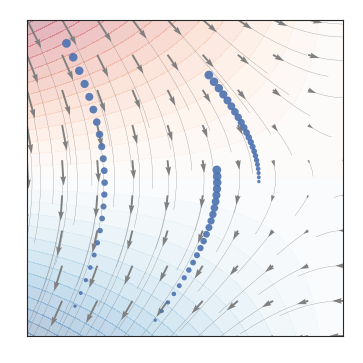

In [15]:
energy_func = lambda x, y: y - 0.5 * x * y
dynamics_func = dynamics_from_energy(energy_func)

fig, ax = plt.subplots(figsize=(1.7, 1.7))

plot_energy_func(ax, energy_func)
plot_trajectory_field(ax, dynamics_func,
                      n_steps=20,
                      step_size=0.05)
plot_vector_field(ax, dynamics_func)
plot_trajectories(ax, dynamics_func, 
                  s0=[[-1.5, 0.4, 0.3], [1.7, 0.1, 1.3]],
                  final_marker=False,
                  n_steps=22,
                  step_size=0.1)

ax.set(xlim=(-2, 2), ylim=(-2, 2),
       xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

plt.savefig('saved/dynamics-example.png', dpi=300)
plt.show()

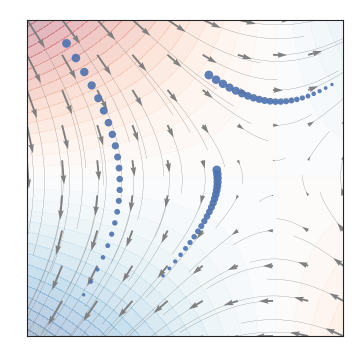

In [17]:
energy_func = lambda x, y: 0.8 * y - 0.7 * x * y
dynamics_func = dynamics_from_energy(energy_func)

fig, ax = plt.subplots(figsize=(1.7, 1.7))

plot_energy_func(ax, energy_func)
plot_trajectory_field(ax, dynamics_func,
                      n_steps=20,
                      step_size=0.05)
plot_vector_field(ax, dynamics_func)
plot_trajectories(ax, dynamics_func, 
                  s0=[[-1.5, 0.4, 0.3], [1.7, 0.1, 1.3]],
                  final_marker=False,
                  n_steps=22,
                  step_size=0.1)

ax.set(xlim=(-2, 2), ylim=(-2, 2),
       xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

plt.savefig('saved/dynamics-input.png', dpi=300)
plt.show()

## Attractors

In [4]:
from jax.scipy.stats.multivariate_normal import pdf as mvn_pdf

def mog_energy(mus, covs, weights):
    mus = [jnp.array(mu) for mu in mus]
    covs = [jnp.array(cov) for cov in covs]
    def mog(x):
        return jnp.stack([weights[i] * mvn_pdf(x, mus[i], covs[i]) 
                          for i in range(len(mus))], axis=-1).sum(axis=-1)
    return lambda x, y: -mog(jnp.stack([x, y], axis=-1))


energy_func = mog_energy(mus=[[-0.8, 1.5], 
                              [1.25, -1.0], 
                              [3, 3], 
                              [-3, -2]],
                         covs=[[[0.4, 0], [0, 0.4]], 
                               [[0.65, -0.15], [-0.15, 0.5]], 
                               [[10, 0], [0, 10]], 
                               [[6, 0], [0, 6]]],
                         weights=[0.4, 
                                  0.6,
                                  -15,
                                  12])
dynamics_func = dynamics_from_energy(energy_func)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


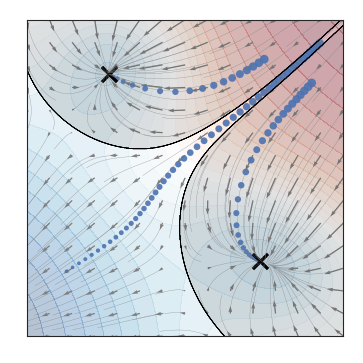

In [25]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))

plot_energy_func(ax, energy_func)
plot_trajectory_field(ax, dynamics_func,
                      n_points=15,
                      n_steps=20,
                      step_size=0.5)
plot_vector_field(ax, dynamics_func,
                  n_points=15)
plot_basins_of_attraction(ax, dynamics_func)
plot_trajectories(ax, dynamics_func, 
                  s0=[[1.0, 1.6, 1.7], [1.5, 1.2, 1.7]],
                  trajectory_clip=[20, 30, None],
                  final_marker=[True, True, False])

ax.set(xlim=(-2, 2), ylim=(-2, 2),
       xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

plt.savefig('saved/attractors-example.png', dpi=300)
plt.show()

## 3-bit flip-flop

Data taken from [this code base](https://github.com/aude-forcione-lambert/an-investigation-of-memory-implementation-in-discrete-recurrent-neural-network/blob/master/analysis.ipynb)

In [99]:
from jax.scipy.linalg import svd


def tension_to_index(tension):
    tension = jnp.round(tension)
    return int((tension[0]+1)/2+(tension[1]+1)+2*(tension[2]+1))


def pca_transform(X, n_components):
    U, _, _ = svd(X - X.mean(axis=0), full_matrices=False)
    return U[:, :n_components]

states = np.loadtxt('data/3-bit-flip-flop_trajectories.gz')
states = pca_transform(states, n_components=3)
states = states[:3000]

color_map = ('indianred','darkorange','gold','lime','turquoise','royalblue','blueviolet','magenta')
colors = np.loadtxt('data/3-bit-flip-flop_output.gz')
colors = colors[:3000]
colors = [tension_to_index(c) for c in colors]
colors = [color_map[c] for c in colors]

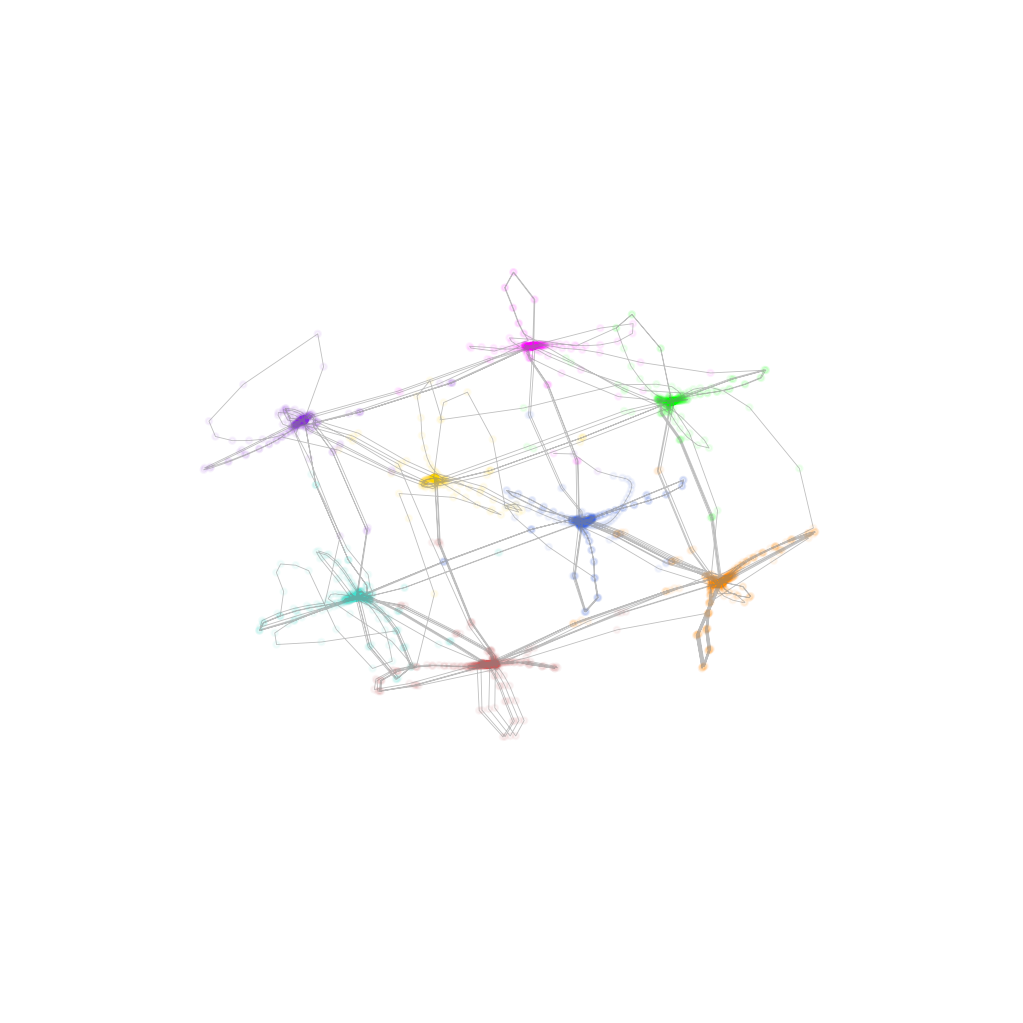

In [140]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.plot(states[:, 0], states[:, 1], states[:, 2], color='gray', linewidth=0.3, alpha=0.5)
ax.scatter(states[:, 0], states[:, 1], states[:, 2], color=colors, 
           s=5, alpha=0.05)

ax.set_axis_off()
ax.view_init(elev=15, azim=-40)

plt.savefig('saved/attractors-3-bit-flip-flop.png')

## Presentation diagrams

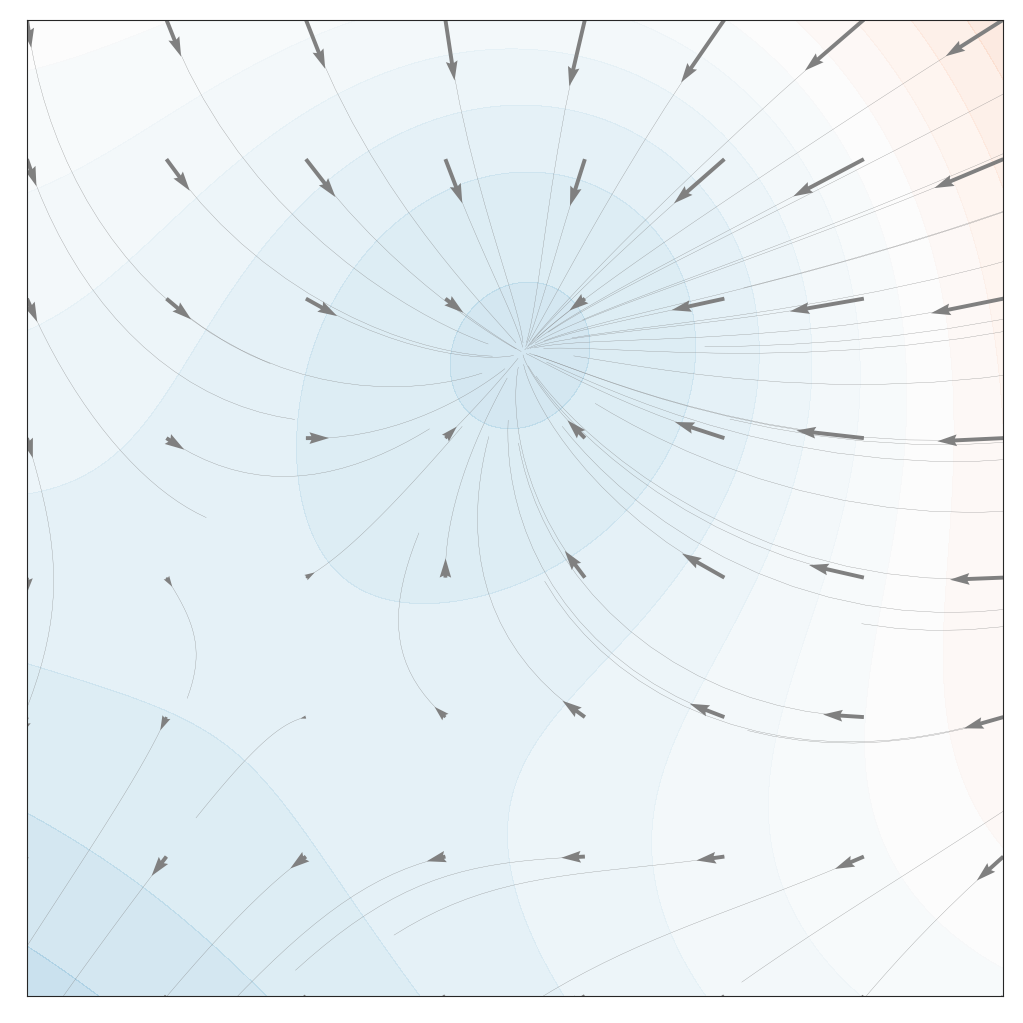

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_energy_func(ax, energy_func)
plot_trajectory_field(ax, dynamics_func,
                      n_points=15,
                      n_steps=20,
                      step_size=0.5)
plot_vector_field(ax, dynamics_func,
                  n_points=15)

ax.set(xlim=(-2, 0), ylim=(0, 2),
       xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

plt.savefig('saved/attractors-zoomed.png', dpi=300)
plt.show()